In [1]:
from sentence_transformers import SentenceTransformer, util
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import math
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from random import sample

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
model_name = 'cross-encoder/nli-deberta-base'

In [3]:
train_set = pd.read_json('./train.jsonl', lines=True)
test_set = pd.read_json('./test.jsonl', lines=True)

In [4]:
encoder = SentenceTransformer(model_name)

No sentence-transformers model found with name /home/azimi/.cache/torch/sentence_transformers/cross-encoder_nli-deberta-base. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/azimi/.cache/torch/sentence_transformers/cross-encoder_nli-deberta-base were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
corpus_embeddings = encoder.encode(train_set['context'], show_progress_bar= True)

Batches:   0%|          | 0/3140 [00:00<?, ?it/s]

In [6]:
embeddings_file = open('./sbert_train_embeddings.pkl', 'wb')
pickle.dump(corpus_embeddings, embeddings_file)
embeddings_file.close()

In [7]:
embeddings_file = open('./sbert_train_embeddings.pkl', 'rb')
data = pickle.load(embeddings_file)
embeddings_file.close()

In [8]:
num_clusters = 3

In [9]:
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)

clustering_model.fit(data)

cluster_assignment = clustering_model.labels_

In [10]:
embedding_score = metrics.silhouette_score(data, cluster_assignment)

print(embedding_score)

0.20366982


In [11]:
clustered_sentences = [[] for i in range(num_clusters)]

dist = clustering_model.transform(data)
clustered_dists = [[] for i in range(num_clusters)]
clustered_idx = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in tqdm(enumerate(cluster_assignment)):
    clustered_sentences[cluster_id].append(train_set['context'].iloc[sentence_id])
    clustered_dists[cluster_id].append(dist[sentence_id][cluster_id])
    clustered_idx[cluster_id].append(sentence_id)

100459it [00:00, 124805.94it/s]


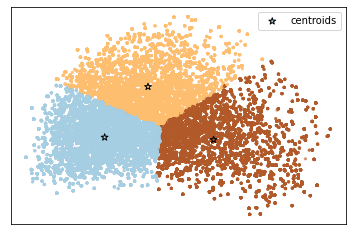

In [12]:
y_km = clustering_model.fit_predict(data)
pca_model = PCA(n_components=2, random_state=42)
transformed = pca_model.fit_transform(data)
centers = pca_model.transform(clustering_model.cluster_centers_)
test_data
plt.scatter(x=transformed[:, 0], y=transformed[:, 1], c=y_km, s=5, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(centers[:, 0],centers[:, 1],
        s=50, marker='*', label='centroids',
        edgecolor='black',
        c=np.arange(0,num_clusters),cmap=plt.cm.Paired,)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

In [16]:
test_embeddings = encoder.encode(test_set['context'], show_progress_bar= True)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

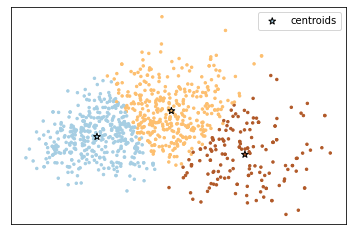

In [21]:
y_km = clustering_model.fit_predict(test_embeddings)
pca_model = PCA(n_components=2, random_state=42)
transformed = pca_model.fit_transform(test_embeddings)
centers = pca_model.transform(clustering_model.cluster_centers_)

plt.scatter(x=transformed[:, 0], y=transformed[:, 1], c=y_km, s=6, cmap=plt.cm.Paired, alpha=1)
plt.scatter(centers[:, 0],centers[:, 1],
        s=50, marker='*', label='centroids',
        edgecolor='black',
        c=np.arange(0,num_clusters),cmap=plt.cm.Paired,)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()

In [27]:
dists_from_centers = np.empty(shape=(num_clusters, data.shape[0]), dtype='object')

for i in tqdm(range(num_clusters)):
    dists_from_centers[i] = np.array(list(map(lambda row: np.sqrt(np.sum(np.square(row - clustering_model.cluster_centers_[i]))), data)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


In [30]:
train_set['cluster'] = ''

for i in range(num_clusters):
  for j in clustered_idx[i]:
    train_set.at[j, 'cluster'] = i

In [34]:
train_set['dist_0'] = dists_from_centers[0]
train_set['dist_1'] = dists_from_centers[1]
train_set['dist_2'] = dists_from_centers[2]

In [35]:
df_centers = pd.DataFrame(columns= train_set.columns)

for i in range(num_clusters):
  df_centers = df_centers.append(train_set[train_set['label'] == 'n'].sort_values('dist_%d'%i).iloc[0])
  df_centers = df_centers.append(train_set[train_set['label'] == 'c'].sort_values('dist_%d'%i).iloc[0])
  df_centers = df_centers.append(train_set[train_set['label'] == 'e'].sort_values('dist_%d'%i).iloc[0])

In [36]:
df_centers

,uid,context,hypothesis,label,model_label,emturk,genre,reason,tag,cluster,dist_0,dist_1,dist_2
9254,8fab1cf3-41f8-437c-8b3e-ff1fd7a8bc5f,Über Goober A Film About Gamers is a 2004 inde...,Interviews with Gary Gygax and Bob Larson have...,n,n,False,wikipedia,"The context says that the film, Über Goober A ...",r3_train,0,3.858338,11.036467,17.762461
36990,086038bc-64c1-4146-9757-26c61bcc65ed,Über Goober A Film About Gamers is a 2004 inde...,Über Goober A Film About Gamers did not win an...,c,c,False,wikipedia,,r3_train,0,3.858338,11.036467,17.762461
33251,448c4b17-cfc7-445a-9eb3-23d296a4db14,Über Goober A Film About Gamers is a 2004 inde...,uber goober a film about gamers was released i...,e,e,False,wikipedia,,r3_train,0,3.858338,11.036467,17.762461
94285,dcc4da33-10c7-445e-9e0b-2c71f16fef2f,The Extra Girl (1923) is a story of a small-to...,King Vidors Show People starred Mabel Normand.,n,n,False,rte,,r3_train,1,10.810854,4.526305,12.098811
100156,3de43e58-ae9e-42fd-8ca1-7d4243bd08fc,The Extra Girl (1923) is a story of a small-to...,"a story of a small-town girl, Sue Graham (play...",c,c,False,rte,,r3_train,1,10.810854,4.526305,12.098811
95260,1df8ab84-32f3-4c87-aff0-2de1b569d0cd,The Extra Girl (1923) is a story of a small-to...,Mack Sennett produced a movie in the 1920's.,e,e,False,rte,,r3_train,1,10.810854,4.526305,12.098811
59210,450041bf-857f-4bf8-bee4-571a7344a5f1,"The Pearls of the Crown (French: ""Les Perles d...",The Pearls of the Crown took 4 years to produce.,n,n,False,wikipedia,,r3_train,2,18.151690,12.314720,4.368387
84591,58f8b25a-7013-40da-a7c0-80cf1358abca,Pink Sweat is a 2009 American music video dire...,Pink Sweat is a 2009 American music video dire...,c,c,False,wikipedia,,r3_train,2,17.401253,11.759456,3.916773
82515,ee1ecb21-d8ce-401b-847c-af371881df71,Pink Sweat is a 2009 American music video dire...,There is vocal entertainment in Pink Sweat.,e,e,False,wikipedia,,r3_train,2,17.401253,11.759456,3.916773
